In [1]:
# !pip install gdown --user

In [2]:
# get data

import gdown

url = 'https://drive.google.com/uc?id=153t6sXT6S3aTPMwuUiXYNFav0XgiSBY4'
output = 'data_acc.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=153t6sXT6S3aTPMwuUiXYNFav0XgiSBY4
To: /home/jovyan/PreprocessingGPU/JupyterExamples/data_acc.csv
476MB [00:11, 42.5MB/s] 


'data_acc.csv'

In [3]:
import cudf
import cuml
import dask_cudf
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import cupy as cp
import numpy as np
import xgboost as xgb

from cuml.cluster.kmeans import KMeans
from cuml.decomposition import PCA

import matplotlib.pyplot as plt

In [4]:
# Создадим вычислительный даск кластер, с GPU воркерами

cluster = LocalCUDACluster()
client = Client(cluster)

In [5]:
# Количество воркеров равно количеству GPU

print(len(cluster.workers))

4


In [6]:
## Distributed GPU approach

In [7]:
df = dask_cudf.read_csv('data_acc.csv')

# изменяем количество партиций по количеству воркеров (ГПУ)
df = df.repartition(npartitions = len(cluster.workers))
df.persist()

,acoustic_data,time_to_failure,seg_id
npartitions=4,,,
,int64,float64,int64
,...,...,...
,...,...,...
,...,...,...
,...,...,...


In [8]:
# Агрегируем данные по номеру сегмента
seg_agg_df = df[['acoustic_data','seg_id']].groupby(['seg_id']).agg(['mean', 'max', 'min'])
seg_agg_df.columns = ['_'.join(col).strip() for col in seg_agg_df.columns.values]
seg_agg_df = seg_agg_df.reset_index()
# Мерджим сагрегированные данные к основному датасету
df = df.merge(seg_agg_df, on='seg_id')

# Создадим еще пару фичей
df['acoustic_data_square'] = df['acoustic_data'] ** 2
df['acoustic_data_diff'] = df['acoustic_data'].diff()

# Заполним пустые значения
df = df.fillna(0)

In [9]:
df

,acoustic_data,time_to_failure,seg_id,acoustic_data_mean,acoustic_data_max,acoustic_data_min,acoustic_data_square,acoustic_data_diff
npartitions=4,,,,,,,,
,int64,float64,int64,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [10]:
X_columns = ['acoustic_data', 'acoustic_data_mean', 'acoustic_data_max',
             'acoustic_data_min', 'acoustic_data_square', 'acoustic_data_diff']

y_column = 'time_to_failure'

In [11]:
# Обучим распредленную GPU модель XGBoost
dtrain = xgb.dask.DaskDMatrix(client, df[X_columns], df[y_column])

In [12]:
output = xgb.dask.train(client,
                        {'verbosity': 2,
                         'tree_method': 'gpu_hist',
                        'n_gpu': len(cluster.workers)},
                        dtrain,
                        num_boost_round=100, 
                        evals=[(dtrain, 'train')])

In [13]:
# Сделаем предсказания

prediction = xgb.dask.predict(client, output, dtrain).compute()

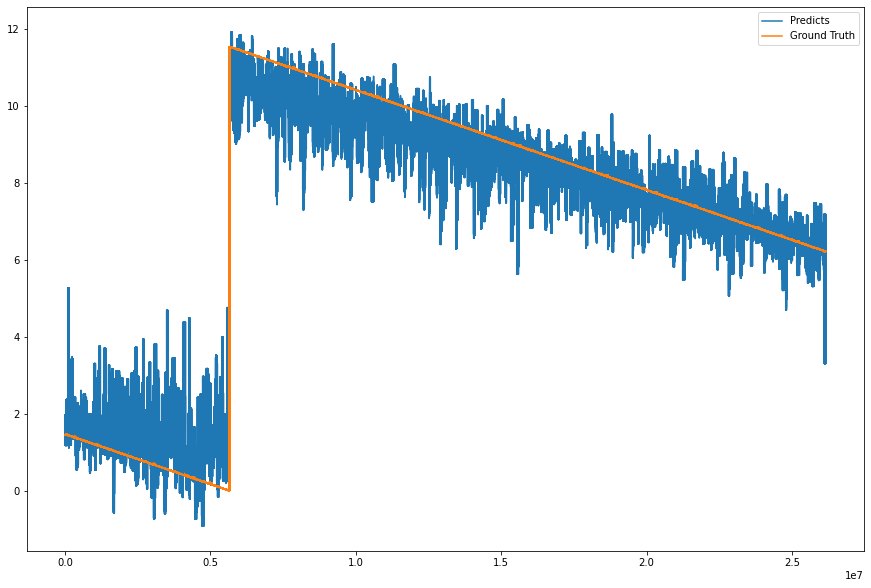

In [14]:
# Постоим предсказания и таргет

plt.figure(figsize=(15,10))
plt.plot(prediction[:50000000], label='Predicts')
plt.plot(df[y_column].values.compute().tolist()[:50000000], label='Ground Truth')
plt.legend()
plt.show()

In [15]:
client.close()
cluster.close()

## Single GPU approach

In [16]:
df = cudf.read_csv('data_acc.csv')

In [17]:
# Агрегируем данные по номеру сегмента
seg_agg_df = df.groupby('seg_id')['acoustic_data'].agg(['mean', 'max', 'min']).reset_index()

# Мерджим сагрегированные данные к основному датасету
df = df.merge(seg_agg_df, on='seg_id')

df['acoustic_data'] = df['acoustic_data'].astype('float64')

In [18]:
X_columns = ['acoustic_data', 'mean',  'max', 'min']
y_column = 'time_to_failure'

In [19]:
# Kmeans модель кластеризации  из библиотеки cuml

kmeans_cuml = KMeans(init="k-means||",
                       n_clusters=5,
                       random_state=100)

labels = kmeans_cuml.fit_predict(df[X_columns])

In [20]:
labels.unique()

0    0
1    1
2    2
3    3
4    4
dtype: int32

In [21]:
# Воспользуемся методом главных компонент из библиотеки cuml

pca = PCA(n_components=3)
pca_data = pca.fit_transform(df[X_columns])

In [22]:
pca_data.head()

,0,1,2
0,1.845668,-9.780297,-2.460873
1,1.845770,-9.777259,0.539125
2,1.845702,-9.779285,-1.460873
3,1.845736,-9.778272,-0.460874
4,1.845770,-9.777259,0.539125


In [23]:
# Обучим GPU модель XGBoost 

dtrain = xgb.DMatrix(pca_data, df[y_column])

In [24]:
model = xgb.train({'tree_method': 'gpu_hist'},
                   dtrain,
                   num_boost_round=200,
                   verbose_eval=40,
                   evals=[(dtrain, 'train')])

[0]	train-rmse:5.78003
[40]	train-rmse:2.30496
[80]	train-rmse:2.01111
[120]	train-rmse:1.87829
[160]	train-rmse:1.81207
[199]	train-rmse:1.77950


In [25]:
# Сделаем предсказания

prediction = model.predict(dtrain)

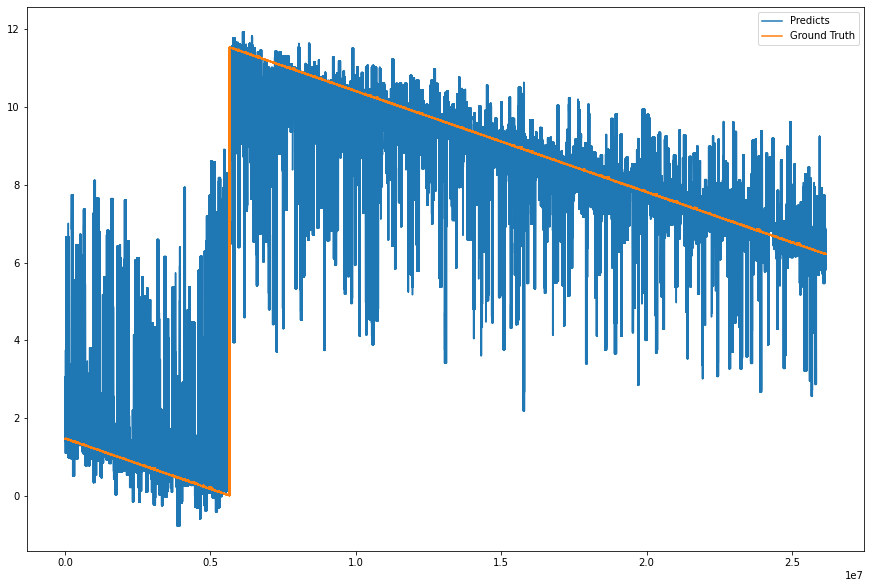

In [26]:
# Постоим предсказания и таргет

plt.figure(figsize=(15,10))
plt.plot(prediction[:50000000], label='Predicts')
plt.plot(df[y_column].values.tolist()[:50000000], label='Ground Truth')
plt.legend()
plt.show()